In [2]:

!pip3 install wordninja==2.0.0             # for splitting joined words
!pip3 install scikit-learn==0.22.2         # for one-hot encoding
!pip3 install lime==0.2.0                  # for explaining model predictions
!pip3 install tensorflow

     |████████████████████████████████| 542kB 8.0MB/s 
  Created wheel for wordninja: filename=wordninja-2.0.0-cp37-none-any.whl size=541554 sha256=3c5c3d0b8d1113583f83e0b9d3e9c9ae9877a30f1b679aca97ad1f222730dc1c
  Stored in directory: /root/.cache/pip/wheels/22/46/06/9b6d10ed02c85e93c3bb33ac50e2d368b2586248f192a2e22a
Successfully built wordninja
     |████████████████████████████████| 7.1MB 6.1MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 276kB 6.9MB/s 
     |████████████████████████████████| 2.0MB 13.2MB/s 
  Created wheel for lime: filename=lime-0.2.0.0-cp37-none-any.whl size=284182 sha256=5f3b26479f916d51bc3b4ae46d44ec47e8034d37c3f95eb55e8ae45deff95c8c
  Stored in directory: /root/.cache/pip/wheels/22/f2/ec/e5ebd07348b2b1ac722e91c2f549fcc220f7d5f25497a61232
Successfully built lime
ERROR: bokeh 2.3.1 has requirement pillow>=7.1

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from lime.lime_text import LimeTextExplainer
import tensorflow as tf
# Check if any GPU is detected
print("Is GPU available: ", tf.test.is_gpu_available())
print("GPU(s) found: ")
print(tf.config.experimental.list_physical_devices('GPU'))

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is GPU available:  False
GPU(s) found: 
[]


In [5]:
data = pd.read_csv("/content/drive/My Drive/3359 project/COMP_3359_GROUP8-main/data/train.csv")

In [7]:
data

,id,tweet
0,2,Stuning even for the non-gamer: This sound tra...
1,2,The best soundtrack ever to anything.: I'm rea...
2,2,Amazing!: This soundtrack is my favorite music...
3,2,Excellent Soundtrack: I truly like this soundt...
4,2,"Remember, Pull Your Jaw Off The Floor After He..."
...,...,...
3599995,1,Don't do it!!: The high chair looks great when...
3599996,1,"Looks nice, low functionality: I have used thi..."
3599997,1,"compact, but hard to clean: We have a small ho..."
3599998,1,what is it saying?: not sure what this book is...


In [6]:
data=data.sample(frac=0.01, replace=False, random_state=1).reset_index().drop(columns = ["index"])

In [7]:
glove_path ="/content/drive/My Drive/3359 project/glove.6B.50d.txt"

In [21]:
from string import punctuation
from collections import defaultdict
import numpy as np

def load_embedding_from_disks(glove_filename, with_indexes=True):
    """
    Read a GloVe txt file. If `with_indexes=True`, we return a tuple of two dictionnaries
    `(word_to_index_dict, index_to_embedding_array)`, otherwise we return only a direct 
    `word_to_embedding_dict` dictionnary mapping from a string to a numpy array.
    """
    if with_indexes:
        word_to_index_dict = dict()
        index_to_embedding_array = []
    else:
        word_to_embedding_dict = dict()

    
    with open(glove_filename, 'r') as glove_file:
        for (i, line) in enumerate(glove_file):
            
            split = line.split(' ')
            
            word = split[0]
            
            representation = split[1:]
            representation = np.array(
                [float(val) for val in representation]
            )
            
            if with_indexes:
                word_to_index_dict[word] = i
                index_to_embedding_array.append(representation)
            else:
                word_to_embedding_dict[word] = representation

    _WORD_NOT_FOUND = [0.0]* len(representation)  # Empty representation for unknown words.
    if with_indexes:
        _LAST_INDEX = i + 1
        word_to_index_dict = defaultdict(lambda: _LAST_INDEX, word_to_index_dict)
        index_to_embedding_array = np.array(index_to_embedding_array + [_WORD_NOT_FOUND])
        return word_to_index_dict, index_to_embedding_array
    else:
        word_to_embedding_dict = defaultdict(lambda: _WORD_NOT_FOUND)
        return word_to_embedding_dict


def sentence_to_word_ids(sentence, word_to_index):
    """
    Note: there might be a better way to split sentences for GloVe.
    Please look at the documentation or open an issue to suggest a fix.
    """
    # Separating punctuation from words:
    for punctuation_character in punctuation:
        sentence = sentence.replace(punctuation_character, " {} ".format(punctuation_character))
    # Removing double spaces and lowercasing:
    sentence = sentence.replace("  ", " ").replace("  ", " ").lower().strip()
    # Splitting on every space:
    split_sentence = sentence.split(" ")
    # Converting to IDs:
    ids = [word_to_index[w.strip()] for w in split_sentence]
    return ids, split_sentence

In [9]:
word_to_index_dict, index_to_embedding_array = load_embedding_from_disks(glove_path, with_indexes=True)
index_to_embedding_array.shape

(400002, 50)

In [17]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
X = data['tweet'].to_numpy()
y_beforelabel = data['id'].to_numpy()
le_y = preprocessing.LabelEncoder()
oe_y = preprocessing.OneHotEncoder()
temp_y = le_y.fit_transform(y_beforelabel).reshape(-1, 1)
X_train, X_traindev, temp_y_train, temp_y_traindev = train_test_split(X, temp_y, test_size=0.2, random_state=42)
y_train = oe_y.fit_transform(temp_y_train).toarray()
y_traindev = oe_y.fit_transform(temp_y_traindev).toarray()

In [42]:
X_train

array(["I don't like it...: I've just boght the armband, it's kinda big, the iphone is loose in it... hard to access the touch screen because it's big...\n",
       'Pest Control Unit: I have had this unit installed since receiving it, seems to work just fine, I rarely notice any pests in our home, spiders and etc.\n',
       "No Other Zorro Need Apply: Banderas and Hopkins should have taken notes from Alain Delon and Stanley Baker! Unequivocally the greatest dual committed to film. Alain Delon and Stanley Baker are perfectly cast in this European version that makes all American versions look like a cheap costume party. Fantastic sets, wonderful costumes, the audience member is transported back in time. While far from the plot of Johnston McCulley's 1919 novel, this 1975 version does retain the spirit of his original character. What I don't like is that this version has been mercilessly edited of some key scenes. I would like to encourage all fans of this film to lobby for it's FULL re

In [92]:
def make_complete(x):
    #length = max(map(len, x))
    length = 300
    return np.array([xi+[0]*(length-len(xi)) for xi in x])

In [93]:
make_complete([[1, 4],[1,2,3]])

array([[1, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [94]:
X_train_token = make_complete( sentence_to_word_ids(x, word_to_index_dict)[0] for x in X_train  )
X_traindev_token = make_complete([ sentence_to_word_ids(x, word_to_index_dict)[0] for x in X_traindev ])

In [96]:
X_train_token

array([[    41,   3316,     57, ...,      0,      0,      0],
       [ 19085,    424,   1207, ...,      0,      0,      0],
       [    84,     68,  41268, ...,      0,      0,      0],
       ...,
       [400001,    305,     36, ...,      0,      0,      0],
       [     7,    353,   1720, ...,      0,      0,      0],
       [    37,   5747,    431, ...,      0,      0,      0]])

In [91]:
X_traindev_token.shape

(7200, 276)

In [97]:
BATCH_SIZE = 128
# Training set data pipeline
train_ds_glove = tf.data.Dataset.from_tensor_slices((X_train_token, y_train))   
train_ds_glove = train_ds_glove.shuffle(buffer_size=len(X_train_token))                
train_ds_glove = train_ds_glove.batch(batch_size=BATCH_SIZE)                     
# Test set data pipeline
traindev_ds_glove = tf.data.Dataset.from_tensor_slices((X_traindev_token, y_traindev))
traindev_ds_glove = traindev_ds_glove.batch(batch_size=BATCH_SIZE)

In [98]:
""" Constructing Model with Pre-Trained Word Embedding """

# Get description of word embedding
vocab_size, embedding_dim = index_to_embedding_array.shape
print("Vocab Size: ", vocab_size)
print("Embedding Dim: ", embedding_dim)

# Construct embedding layer and use embedding vectors to set weights.
# Set trainable=False to freeze the weights to prevent weight to be 
# changed during training.
embedding_layer = tf.keras.layers.Embedding(input_dim=vocab_size, 
                                            output_dim=embedding_dim,
                                            weights=[index_to_embedding_array],
                                            trainable=False)

# Construct model using the pre-trained embedding layer.
# This model learns by changing network weights in Dense layer.
# (no trainable weights in GlobalAveragePooling layer)
model_glove = tf.keras.Sequential([
    embedding_layer,
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])
print(model_glove.summary())

# Compile model
model_glove.compile(loss='categorical_crossentropy',
                    optimizer=tf.keras.optimizers.Adam(1e-2),
                    metrics=['accuracy'])

# Train model
history = model_glove.fit(train_ds_glove, epochs=30,
                          validation_data=traindev_ds_glove, 
                          validation_steps=30,
                          verbose=1)

Vocab Size:  400002
Embedding Dim:  50
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 50)          20000100  
_________________________________________________________________
global_average_pooling1d_2 ( (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 52        
Total params: 20,001,427
Trainable params: 1,327
Non-trainable params: 20,000,100
_________________________________________________________________
None
Epoch 1/30
225/225 [==============================] - 3s 8ms/step - loss: 0.6706 - accuracy: 0.5796 - val_loss: 0.6102 - val_accuracy: 0.6458
Epoch 2/30
225/225 [==============================

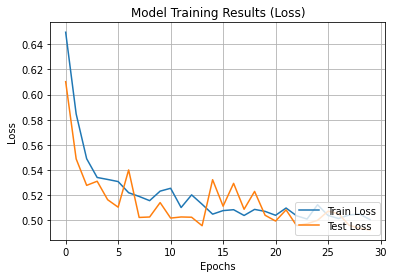

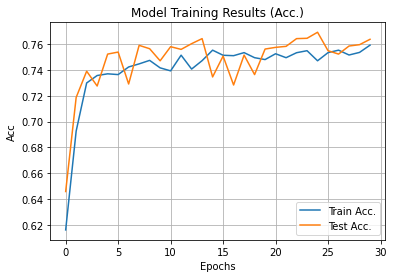

In [99]:

##### Loss #####
# Get training results
history_dict = history.history
train_loss = history_dict['loss']
test_loss = history_dict['val_loss']

# Plot training results
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')

# Show plot
plt.title('Model Training Results (Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="lower right")
plt.grid()
plt.show()

##### Accuracy #####
# Get training results
history_dict = history.history
train_acc = history_dict['accuracy']
test_acc = history_dict['val_accuracy']

# Plot training results
plt.plot(train_acc, label='Train Acc.')
plt.plot(test_acc, label='Test Acc.')

# Show plot
plt.title('Model Training Results (Acc.)')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend(loc="lower right")
plt.grid()

In [100]:

# prediction example
from scipy import stats
example = X_train[0]
corresponding_output = y_train[0]

print("Sentence: \n",
      example, "\n")
ids = sentence_to_word_ids(example, word_to_index_dict)[0]
print("Corresponding ids: \n",
      ids, "\n")
predictions = np.amin(model_glove.predict(ids), axis=0)
print("Corresponding predictions: \n",
      predictions, "\n")
print("Final prediction: \n", 
      le_y.inverse_transform(stats.mode(predictions)[0].astype(int))[0], "\n")
print("Actual categorization: \n", 
     list(le_y.classes_)[oe_y.inverse_transform([corresponding_output])[0][0]])

Sentence: 
 I don't like it...: I've just boght the armband, it's kinda big, the iphone is loose in it... hard to access the touch screen because it's big...
 

Corresponding ids: 
 [41, 3316, 57, 2159, 117, 20, 2, 2, 2, 45, 41, 57, 37138, 120, 400001, 0, 47683, 1, 20, 57, 1534, 35541, 365, 1, 0, 11693, 14, 5128, 6, 20, 2, 2, 2, 605, 4, 1122, 0, 3255, 2491, 113, 20, 57, 1534, 365, 2, 2, 2] 

Corresponding predictions: 
 [9.1138154e-26 2.1289324e-12] 

Final prediction: 
 1 

Actual categorization: 
 1
